I had to install the 'seaborn' module with `conda install -c anaconda seaborn`

Taken from:
https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Mounted at /content/drive


In [2]:
data_dir = pathlib.Path('/content/drive/My Drive/data')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = commands[commands != '.ipynb_checkpoints']
print('Commands:', commands)

Commands: ['no' 'china']


In [4]:

!pwd

/content


In [5]:
num_train_files = 50
num_val_files = 5
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
num_samples = len(filenames)
num_test_files = num_samples - num_train_files - num_val_files
train_files = filenames[:num_train_files]
val_files = filenames[num_train_files: num_train_files + num_val_files]
test_files = filenames[-num_test_files:]
print(test_files)
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

['/content/drive/My Drive/data/no/0c5027de_nohash_0.wav', '/content/drive/My Drive/data/no/e77d88fc_nohash_0.wav', '/content/drive/My Drive/data/no/2f813234_nohash_0.wav', '/content/drive/My Drive/data/no/e57d35bc_nohash_2.wav', '/content/drive/My Drive/data/no/2dcb6848_nohash_0.wav', '/content/drive/My Drive/data/no/e57d35bc_nohash_1.wav', '/content/drive/My Drive/data/no/e57d35bc_nohash_0.wav', '/content/drive/My Drive/data/no/2e0d80f7_nohash_2.wav', '/content/drive/My Drive/data/no/0c2d2ffa_nohash_0.wav', '/content/drive/My Drive/data/no/2bfe70ef_nohash_0.wav', '/content/drive/My Drive/data/no/2e0d80f7_nohash_0.wav', '/content/drive/My Drive/data/no/2bfe70ef_nohash_1.wav', '/content/drive/My Drive/data/no/0c2ca723_nohash_0.wav', '/content/drive/My Drive/data/no/cee22275_nohash_1.wav', '/content/drive/My Drive/data/no/0f7dc557_nohash_1.wav', '/content/drive/My Drive/data/no/e63b69c5_nohash_0.wav', '/content/drive/My Drive/data/no/0f3f64d5_nohash_0.wav', '/content/drive/My Drive/data/

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

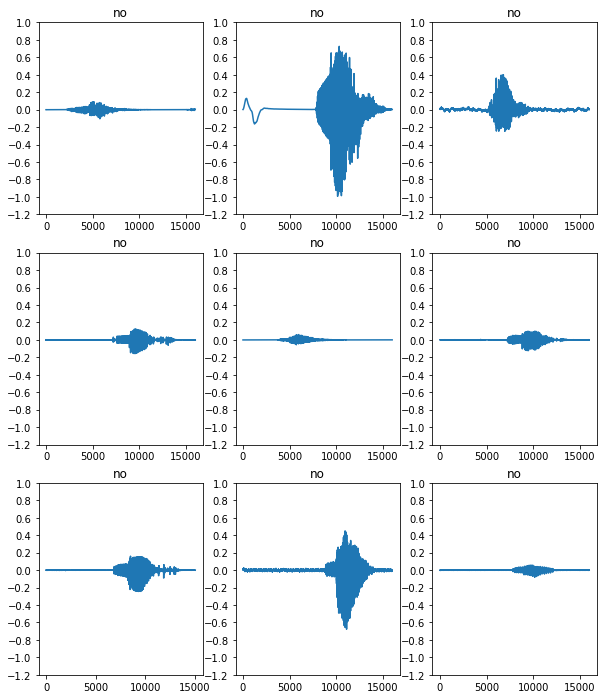

In [10]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [11]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [12]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


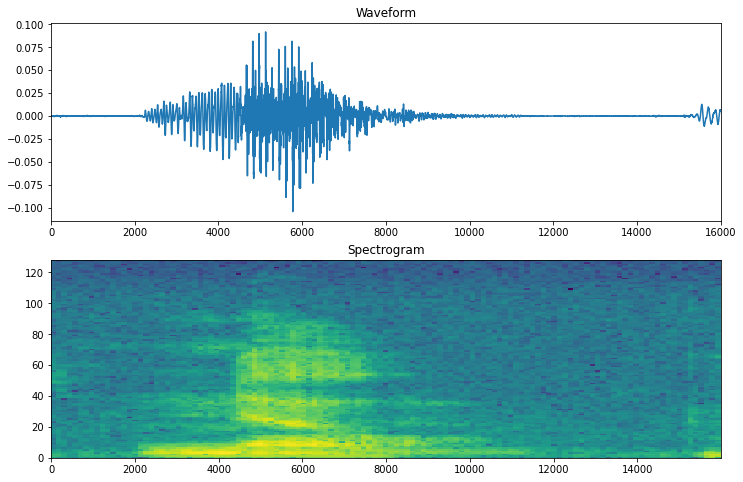

In [13]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


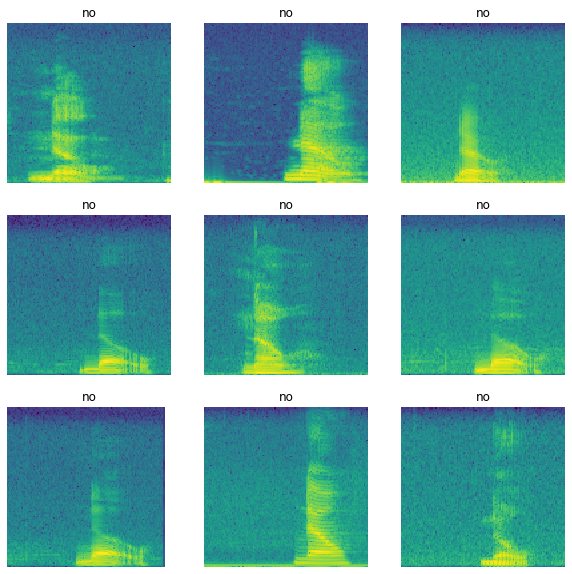

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [17]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id)
  return output_ds

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [19]:
batch_size = 2
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [20]:
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
#val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [21]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), # downsamples in both dimensions (~4x) to 32x32.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [58]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [70]:
# Create the teacher
teacher = keras.Sequential(
    [
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), # downsamples in both dimensions (~4x) to 32x32.
    norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), # downsamples in both dimensions (~4x) to 32x32.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
    ],
    name="student",
)

teacher.summary()
student.summary()

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 30, 30, 128)       1280      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 50176)             0   

In [71]:
# Prepare the train and test dataset.
batch_size = 3

# train_ds = spectrogram_ds
# val_ds = preprocess_dataset(val_files)
# test_ds = preprocess_dataset(test_files)

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# # Normalize data

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))


Input shape: (124, 129, 1)


In [72]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
# teacher.fit(x_train, y_train, epochs=5)
# teacher.evaluate(x_test, y_test)

teacher.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)



Epoch 1/64
25/25 [==============================] - 3s 120ms/step - loss: 5.7347 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/64
25/25 [==============================] - 3s 114ms/step - loss: 1.8899 - sparse_categorical_accuracy: 0.1898 - val_loss: 0.3303 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/64
25/25 [==============================] - 3s 114ms/step - loss: 0.9047 - sparse_categorical_accuracy: 0.3962 - val_loss: 0.2474 - val_sparse_categorical_accuracy: 1.0000
Epoch 00003: early stopping


In [76]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
history = distiller.fit(train_ds, validation_data=val_ds, epochs=3)
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
# Evaluate student on test dataset
# distiller.evaluate(test_ds, val_ds)

Epoch 1/3
25/25 [==============================] - 2s 48ms/step - sparse_categorical_accuracy: 0.8768 - student_loss: 0.1773 - distillation_loss: 0.0088 - val_sparse_categorical_accuracy: 1.0000 - val_student_loss: 0.2879
Epoch 2/3
25/25 [==============================] - 1s 44ms/step - sparse_categorical_accuracy: 0.9442 - student_loss: 0.2056 - distillation_loss: 0.0085 - val_sparse_categorical_accuracy: 0.4000 - val_student_loss: 0.8510
Epoch 3/3
25/25 [==============================] - 1s 43ms/step - sparse_categorical_accuracy: 0.9757 - student_loss: 0.1266 - distillation_loss: 0.0067 - val_sparse_categorical_accuracy: 0.8000 - val_student_loss: 0.3772


KeyError: ignored

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 64  # was 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/64
25/25 [==============================] - 4s 137ms/step - loss: 1.9936 - accuracy: 0.7195 - val_loss: 0.5995 - val_accuracy: 1.0000
Epoch 2/64
25/25 [==============================] - 1s 28ms/step - loss: 0.6994 - accuracy: 0.3331 - val_loss: 0.2875 - val_accuracy: 1.0000
Epoch 3/64
25/25 [==============================] - 1s 28ms/step - loss: 0.9139 - accuracy: 0.5620 - val_loss: 0.3286 - val_accuracy: 1.0000
Epoch 4/64
25/25 [==============================] - 1s 28ms/step - loss: 0.6668 - accuracy: 0.7409 - val_loss: 0.2260 - val_accuracy: 1.0000
Epoch 5/64
25/25 [==============================] - 1s 28ms/step - loss: 0.4046 - accuracy: 0.7732 - val_loss: 0.1269 - val_accuracy: 1.0000
Epoch 6/64
25/25 [==============================] - 1s 29ms/step - loss: 0.4784 - accuracy: 0.7975 - val_loss: 0.1443 - val_accuracy: 1.0000
Epoch 7/64
25/25 [==============================] - 1s 28ms/step - loss: 0.4359 - accuracy: 0.8582 - val_loss: 0.2974 - val_accuracy: 0.8000
Epoch 00007:

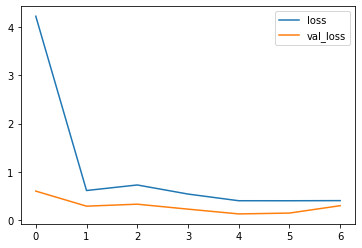

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 95%


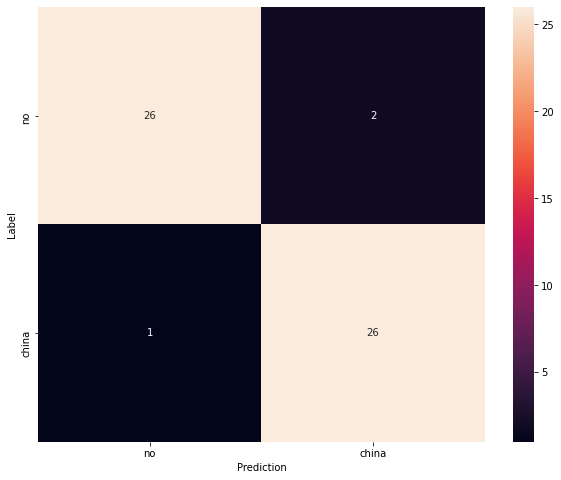

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

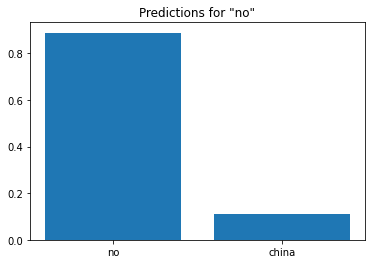

In [29]:
sample_file = '/content/drive/My Drive/no_testing.wav'  ## new test file

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()